## Import Packages


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")


## Loading Data

In [2]:
# Read Data into a Dataframe
df_fraud=pd.read_csv('Fraud.csv')
df_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Descriptive Statistics

In [3]:
df_fraud.shape

(6362620, 11)

In [4]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


The Dataset consists mostly of numerical features except 'type','nameOrig' & 'nameDest' which are object.

### Missing values

In [5]:
pd.DataFrame({"Missing value (%)": df_fraud.isnull().sum()/len(df_fraud.index)*100})

,Missing value (%)
step,0.0
type,0.0
amount,0.0
nameOrig,0.0
oldbalanceOrg,0.0
newbalanceOrig,0.0
nameDest,0.0
oldbalanceDest,0.0
newbalanceDest,0.0
isFraud,0.0


The above dataset has no missing values hence, need not to be handled.

In [6]:
# Describe Data
df_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


From above we can see that data is highly postively skewed, contain outliers.

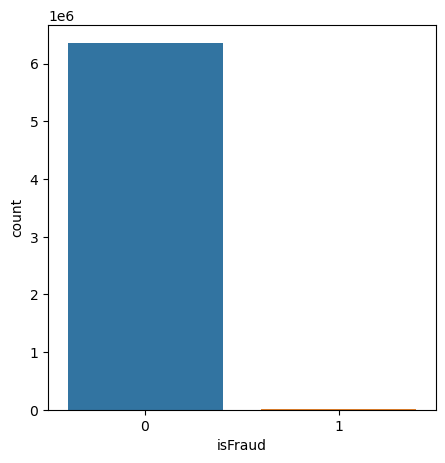

In [7]:
df_fraud['isFraud'].astype('category').value_counts()
plt.figure(figsize=(5,5))
sns.countplot(x=df_fraud['isFraud'], data=df_fraud)
plt.show()


The Dataset is highly imbalanced as evident from the countplot with majority class label '0' and minority class label '1'(fraud).Thus, if we run the model on such imbalanced data we may end up highly overfitting it on the data so need to choose classfier for model wisely

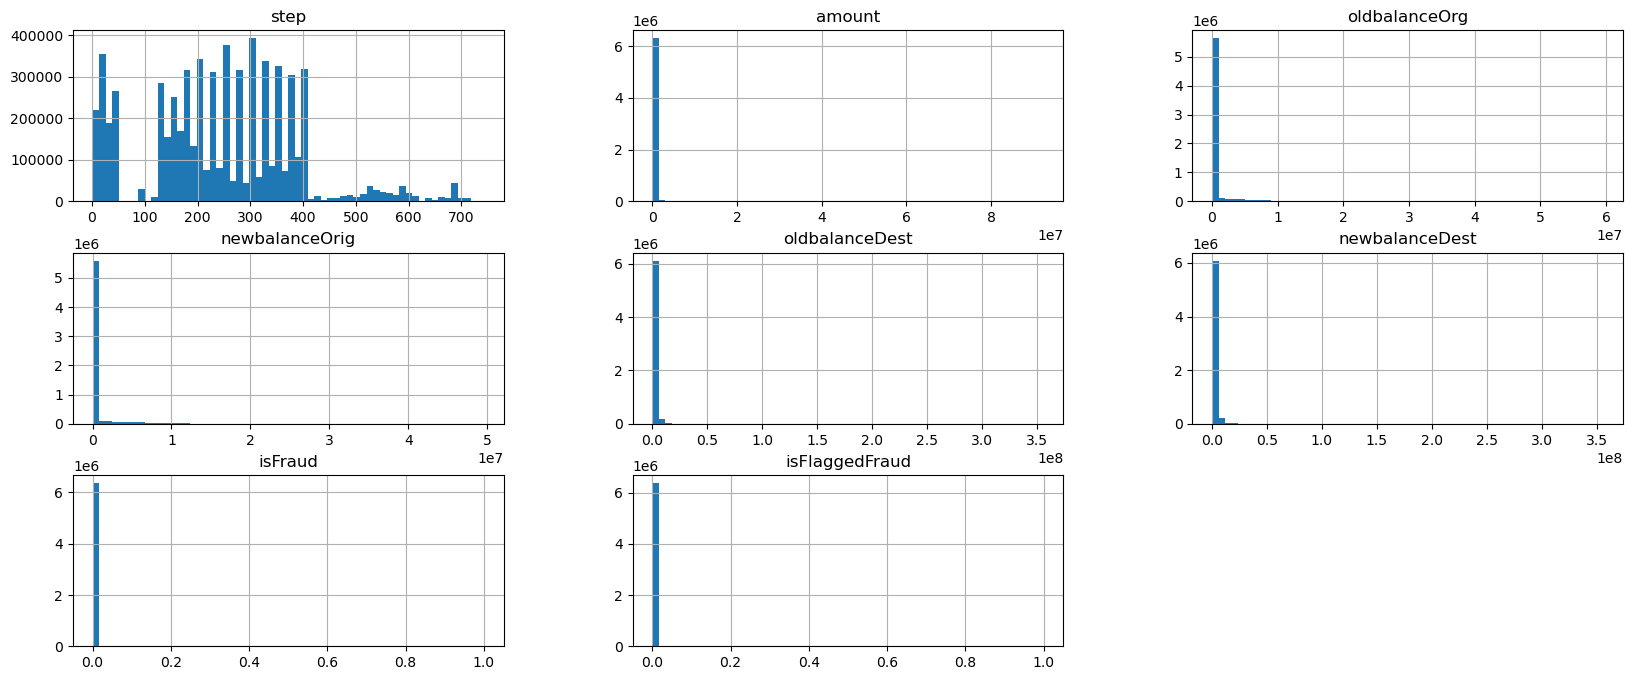

In [8]:
df_fraud.hist(bins=60, figsize=(20,8)) # The histograms below shows all variables distribution
plt.show()

### Correlation

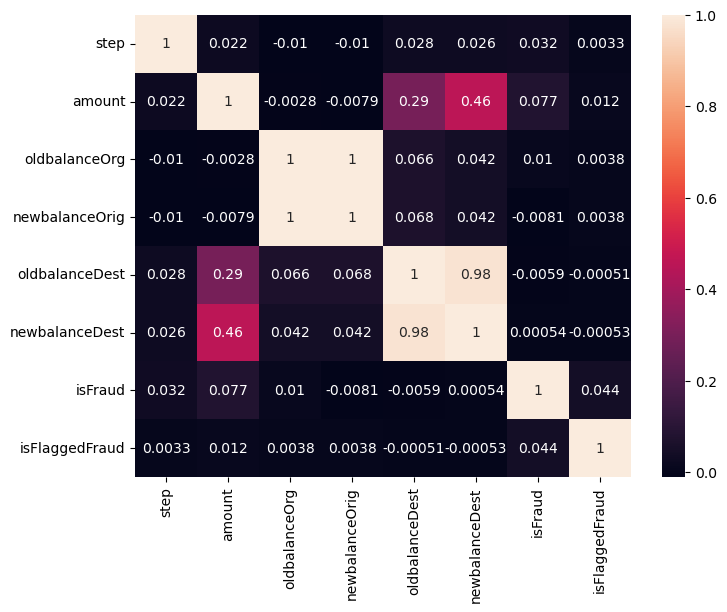

In [12]:
# Displaying correlation matrix using sns library heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_fraud.corr(),annot=True)
plt.show()

<ol>
<li>OldbalanceOrg and NewbalanceOrg are highly correlated.</li>
<li>OldbalanceDest and NewbalanceDest are highly correlated.</li>
<li>Also amount is correlated with isFraud.</li> 
</ol>    

### Muticollinearity
<ol>
<li>Though through correlation matrix we had found correlation but we will detect multicollineartity for each independent variable using variance inflation factor(VIF), larger the VIF, Higher the multicollinearity, High multicollinearty is indicated by a VIF larger than 5 or 10.</li>
<li>VIF can be calculated for numerical variable so we first need to convert our variables with object datatypes, we will follow below steps:-</li>
</ol>

In [13]:
df=df_fraud.copy()
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
obj_col =df.select_dtypes(include = "object").columns
print (obj_col)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


We can use either LabelEncoding or one-hot Encoding to convert above variables into numerical variables.

In [15]:
# Converting object datatype to str/categorical
lab_en = LabelEncoder()

for i in obj_col:
    df[i] =lab_en.fit_transform(df[i].astype(str))

print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 534.0 MB
None


In [16]:
# Detecting multicollineartity using variance inflation factor(VIF) for each independent variable.
def vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["features"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)
vif(df)

,features,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


Above We can see that oldbalanceOrg and newbalanceOrig have very high VIF so they are highly correlated, Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.

## Data Transformation

In [17]:
#Fixing multicolineartity-combine the correlated variables into one and drop the others.
df['actual_amt_Orig'] = df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
df['actual_amt_Dest'] = df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
df['Transaction'] = df.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
df = df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest','isFlaggedFraud'],axis=1)


In [10]:
# vif for df
vif(df)

,features,VIF
0,type,2.687704
1,amount,3.817877
2,isFraud,1.182124
3,actual_amt_Orig,1.307603
4,actual_amt_Dest,3.753624
5,Transaction,2.676987


<AxesSubplot:>

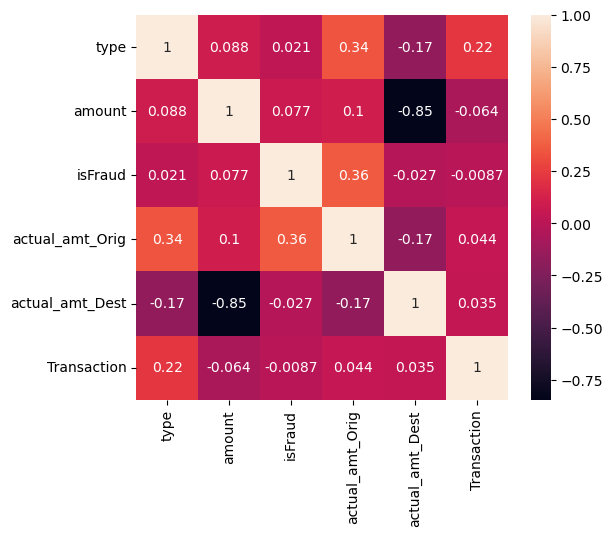

In [18]:
# Heatmap after transformation and dropping columns
corr=df.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr,annot=True)

## Modelling
<ol>
    <li>Create pipeline</li>
    <li>Run GridSearch on data</li>
    <li>Fine tune and evaluation</li>
</ol>

In [19]:
## Create Train and Test Data in ratio 70:30
scaler = StandardScaler()
X = df.drop(["isFraud"], axis= 1) #features
y = df.loc[:,'isFraud']  #target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [20]:
# pipeline for logistic regression classifier
#scaler = StandardScaler()
pipe_lr= Pipeline(steps=[("scaler",scaler),('model', LogisticRegression(random_state=1))])
param_grid_lr = {'model__penalty': ['l1','l2'],
                 'model__class_weight': [None, 'balanced']}
MCC_scorer = make_scorer(matthews_corrcoef) # metric for binary classification
grid_cv_lr = GridSearchCV(estimator=pipe_lr, param_grid=param_grid_lr, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_cv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l1', 'l2']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [21]:
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier 
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('Classification Report')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [22]:
grid_eval(grid_cv_lr)
evaluation(y_test, grid_cv_lr, X_test)

Best Score 0.6149778088205531
Best Parameter {'model__class_weight': None, 'model__penalty': 'l2'}
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.86      0.43      0.58      2464

    accuracy                           1.00   1908786
   macro avg       0.93      0.72      0.79   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC-ROC
0.7166759284557983
F1-Score
0.5768295976235486
Accuracy
0.9991790593602425


In [23]:
# pipeline for Random forest classifier
pipe_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rf = {'model__n_estimators': [50]}
MCC_scorer = make_scorer(matthews_corrcoef)
grid_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf,n_jobs=-1, pre_dispatch='2*n_jobs', scoring=MCC_scorer, cv=5, verbose=1, return_train_score=False)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=-1, param_grid={'model__n_estimators': [50]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [25]:
grid_eval(grid_rf)
evaluation(y_test, grid_rf, X_test)

Best Score 0.8229881165081838
Best Parameter {'model__n_estimators': 50}
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.71      0.81      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC-ROC
0.854686809393766
F1-Score
0.8145386766076421
Accuracy
0.9995829810151583


In [26]:
# pipeline for knn classifier
pipeline_knn = Pipeline(steps=[('scaler',scaler),('model', KNeighborsClassifier(n_neighbors=5))])
param_grid_knn = {'model__p': [2]}
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_knn.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'model__p': [2]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [28]:
grid_eval(grid_knn)
evaluation(y_test, grid_knn, X_test)

Best Score 0.7615005765061587
Best Parameter {'model__p': 2}
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.89      0.65      0.75      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.82      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC-ROC
0.8232045113762073
F1-Score
0.7498234878795011
Accuracy
0.9994431015315494


Out of all the classifier Random forest performed the best, though logistic regression and knn also have 99.9% accuracy but our dataset is imbalanced therefore the accuracy results our biased towards majoritian label'0'(not fraud) while random forest through its own algorithm make the dataset more balanced.


The precision and recall value in KNN and logistic regression is not as good as in random forest, which is important in fraud detection model since the bank wants to predict defaulter as fraud instead of declaring the genuine customers as genuine.

Also the F-1 score(main metric) of Random classifier is better than other two.
AUC becomes biased in imbalanced dataset so not the right metric but it performs pretty better again in random forest than knn,logistic regression.
Suggestion-we can use SMOTE/SMOTENC to make our dataset balanced and can check the performance of different classifier.

<ol>
key factors that predicts fraudulent customers:-
<li>Transaction history, frequency and amount</li>
<li>Organisation/phone number verification if that is fake or real</li>
</ol>



<ol>
kind of prevention companies should adopt in infrastructure
<li>Using cloud technologies with robust security framework.
<li>Alert customers when there is suspicious activity
<li>multi-factor authentication, RECAPTCHA authentication
<li>Avoid fake calls/SMS asking for account details.
<li>prompt when connected to people wi-fi that they are not secured as reminder.
</ol>


<ol>
Assuming these actions have been implemented, how would you determine if they work?
<li>Customers keep check of their E-bank statement regularly.</li>
</ol>